In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datetime import datetime
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from face_alignment import align
from backbones import get_model
import cv2
import os
import random
from collections import defaultdict
import copy

SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [3]:
def measure_brightness(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_val = float(np.mean(gray))
    return mean_val

def scan_brightness(root="data"):
    brightness_list = []
    per_folder_stats = defaultdict(list)

    for folder, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(folder, f)
                mean_val = measure_brightness(path)

                if mean_val is not None:
                    brightness_list.append((path, mean_val))
                    folder_name = os.path.basename(folder)
                    per_folder_stats[folder_name].append(mean_val)

    return brightness_list, per_folder_stats

def summarize_brightness(brightness_list):
    if len(brightness_list) == 0:
        print("❌ Không tìm thấy ảnh nào.")
        return
    
    values = np.array([b for (_, b) in brightness_list])

    print("=== Tổng quan dataset ===")
    print(f"Số ảnh: {len(values)}")
    print(f"Độ sáng trung bình: {values.mean():.2f}")
    print(f"Độ sáng tối thiểu:  {values.min():.2f}")
    print(f"Độ sáng tối đa:     {values.max():.2f}")

    # ảnh tối nhất và sáng nhất
    darkest = min(brightness_list, key=lambda x: x[1])
    brightest = max(brightness_list, key=lambda x: x[1])

    print("\nẢnh tối nhất:")
    print(f"  {darkest[0]}  →  {darkest[1]:.2f}")

    print("\nẢnh sáng nhất:")
    print(f"  {brightest[0]} →  {brightest[1]:.2f}")

brightness_list, per_folder_stats = scan_brightness("data/low_light")

summarize_brightness(brightness_list)

=== Tổng quan dataset ===
Số ảnh: 45
Độ sáng trung bình: 16.98
Độ sáng tối thiểu:  3.83
Độ sáng tối đa:     63.98

Ảnh tối nhất:
  data/low_light/lan/1.jpg  →  3.83

Ảnh sáng nhất:
  data/low_light/tu/IMG_0360.jpg →  63.98


In [31]:
def save_model(model, path):
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        state_dict_path = path.replace('.pt', '_state_dict.pt')
        torch.save(model.state_dict(), state_dict_path)
        print(f"✅ Đã lưu state_dict thành công tại: {state_dict_path}")

    except Exception as e:
        print(f"❌ Lỗi khi lưu mô hình: {e}")

def load_model(model_instance, path):
    checkpoint = torch.load(path)
    model_instance.load_state_dict(checkpoint)
    model_instance.eval() 
    
    print(f"✅ Đã tải và áp dụng state_dict thành công.")
    return model_instance

# Model

In [4]:
class BaselineModel(nn.Module):
    def __init__(self, embed_dim=512, num_classes=7):
        super().__init__()

        model_name="edgeface_xxs"
        backbone = get_model(model_name)
        checkpoint_path = f'checkpoints/{model_name}.pt'
        backbone.load_state_dict(torch.load(checkpoint_path, map_location=device))

        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def unfreeze_last_layers(self, n=2):
        for param in self.backbone.parameters():
            param.requires_grad = False

        layers = list(self.backbone.children())

        for layer in layers[-n:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.backbone(x)
        return self.head(embeddings)

In [5]:
def build_image_dict(root="data", split_by_person=False):
    all_image_dict = defaultdict(list)

    # duyệt: data/low_light/*/, data/normal/*/
    for split in os.listdir(root):
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            continue

        # mỗi split: low_light, normal
        for person in os.listdir(split_path):
            person_path = os.path.join(split_path, person)
            if not os.path.isdir(person_path):
                continue

            if not split_by_person:
                key = f"{split}"
            else:
                key = f"{split}/{person}"

            # lấy toàn bộ ảnh trong thư mục người
            for f in os.listdir(person_path):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    all_image_dict[key].append(os.path.join(person_path, f))

    return all_image_dict

all_image_dict = build_image_dict("data")

for k, v in all_image_dict.items():
    print(k, len(v))

clahe_lighten_low_light 45
normal 43
low_light 45
darken_normal 258


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112,112)),   # tất cả ảnh phải đồng size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5]),
])

def get_embeddings(image_paths, bb):
    bb = bb.to(device)
    bb.eval()

    batch = []

    for image_path in image_paths:
        # aligned = align.get_aligned_face(image_path)

        # if aligned is None:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aligned = img

        aligned = np.asarray(aligned)   # đảm bảo ndarray
        x = transform(aligned)          # (3,112,112)
        batch.append(x)

    batch = torch.stack(batch).to(device)  # (N,3,112,112)
    print("Batch shape:", batch.shape)

    with torch.no_grad():
        emb = bb(batch)

    return emb

# get_embeddings(all_image_dict['normal/son']).shape

In [7]:
def draw_pca(model, class_to_paths: dict, save_path="pca_plot/pca_plot.png"):
    # 1. Lấy embedding cho từng class
    class_embeddings = {}
    for cls, paths in class_to_paths.items():
        if len(paths) == 0:
            continue
        print(f"Extracting embeddings for {cls} ({len(paths)} images)...")
        emb = get_embeddings(paths, model.backbone)   # ⬅️ dùng hàm mới
        class_embeddings[cls] = emb.cpu().numpy()           # (N, embed_dim)

    # 2. Ghép tất cả embedding
    all_embs = np.vstack(list(class_embeddings.values()))

    # 3. PCA -> 2D
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(all_embs)

    # 4. Tách lại theo class
    splitted = {}
    idx = 0
    for cls, emb in class_embeddings.items():
        n = emb.shape[0]
        splitted[cls] = emb_2d[idx:idx+n]
        idx += n

    # 5. Vẽ scatter
    plt.figure(figsize=(10, 8))
    for cls, pts in splitted.items():
        plt.scatter(pts[:, 0], pts[:, 1], label=cls, alpha=0.75, s=30)

    plt.legend()
    plt.title("PCA Projection of Face Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # 6. Lưu file
    os.makedirs('pca_plot', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_path = save_path.replace(".png", f"_{timestamp}.png")
    plt.savefig(final_path, dpi=300)
    plt.close()

    return final_path

# model = BaselineModel()
# all_image_dict = build_image_dict("data")
# all_image_dict.pop('clahe_lighten_low_light')
# all_image_dict.pop('darken_normal')
# draw_pca(model, all_image_dict)

In [8]:
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        # 1. Load ảnh
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # img = np.asarray(img)

        # 3. Transform → tensor
        if self.transform is not None:
            img = self.transform(img)

        return img, label

def load_image_paths(trn_split_list, tst_split_list, root="data"):
    trn_paths = []
    trn_labels = []
    tst_paths = []
    tst_labels = []

    name_id_map = {}     # person -> id
    next_id = 0

    for split in trn_split_list:
        split_dir = os.path.join(root, split)
        if not os.path.isdir(split_dir):
            continue

        for person in os.listdir(split_dir):
            person_dir = os.path.join(split_dir, person)
            if not os.path.isdir(person_dir):
                continue

            # gán label id
            if person not in name_id_map:
                name_id_map[person] = next_id
                next_id += 1

            for f in os.listdir(person_dir):
                if f.lower().endswith((".jpg",".jpeg",".png")):
                    full_path = os.path.join(person_dir, f)
                    trn_paths.append(full_path)
                    trn_labels.append(name_id_map[person])

    for split in tst_split_list:
        split_dir = os.path.join(root, split)
        if not os.path.isdir(split_dir):
            continue

        for person in os.listdir(split_dir):
            person_dir = os.path.join(split_dir, person)
            if not os.path.isdir(person_dir):
                continue

            # gán label id
            if person not in name_id_map:
                name_id_map[person] = next_id
                next_id += 1

            for f in os.listdir(person_dir):
                if f.lower().endswith((".jpg",".jpeg",".png")):
                    full_path = os.path.join(person_dir, f)
                    tst_paths.append(full_path)
                    tst_labels.append(name_id_map[person])

    return trn_paths, trn_labels, tst_paths, tst_labels, name_id_map

def split_low_light(low_paths, low_labels, pct=0.1, seed=SEED):
    """pct = 0.1 → 10% val, 10% test. Còn lại train."""
    N = len(low_paths)
    np.random.seed(seed)
    idx = np.random.permutation(N)

    test_size = int(N * pct)
    val_size  = int(N * pct)

    test_idx = idx[:test_size]
    val_idx = idx[test_size:test_size+val_size]
    train_idx = idx[test_size+val_size:]

    low_train_paths = [low_paths[i] for i in train_idx]
    low_train_labels = [low_labels[i] for i in train_idx]

    low_val_paths = [low_paths[i] for i in val_idx]
    low_val_labels = [low_labels[i] for i in val_idx]

    low_test_paths = [low_paths[i] for i in test_idx]
    low_test_labels = [low_labels[i] for i in test_idx]

    return (low_train_paths, low_train_labels,
            low_val_paths, low_val_labels,
            low_test_paths, low_test_labels)

def build_dataloaders(trn_split_list, tst_split_list, root="data", pct=0.5, batch_size=8, shuffle=True):
    normal_paths, normal_labels, low_paths, low_labels, label_map = load_image_paths(trn_split_list, tst_split_list, root)

    (low_train_paths, low_train_labels,
     low_val_paths, low_val_labels,
     low_test_paths, low_test_labels) = split_low_light(low_paths, low_labels, pct)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((112,112)),   # tất cả ảnh phải đồng size
        transforms.Normalize(mean=[0.5,0.5,0.5],
                             std=[0.5,0.5,0.5]),
    ])
    # transform=None

    # train = normal + phần train của low_light
    train_ds = FaceDataset(
        normal_paths + low_train_paths,
        normal_labels + low_train_labels,
        transform=transform
    )

    val_ds = FaceDataset(
        low_val_paths, low_val_labels,
        transform=transform
    )

    test_ds = FaceDataset(
        low_test_paths, low_test_labels,
        transform=transform
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, label_map

trn_ld, val_ld, tst_ld, name_id_map = build_dataloaders(['normal'], ['low_light'], root="data", pct=0.5, batch_size=4)

print(len(trn_ld.dataset))
print(len(val_ld.dataset))
print(len(tst_ld.dataset))
print(name_id_map)

id_name_map = {v: k for k, v in name_id_map.items()}
# next(iter(trn_ld))

44
22
22
{'khanh': 0, 'tu': 1, 'minh': 2, 'lan': 3, 'dung': 4, 'son': 5, 'kien': 6}


4


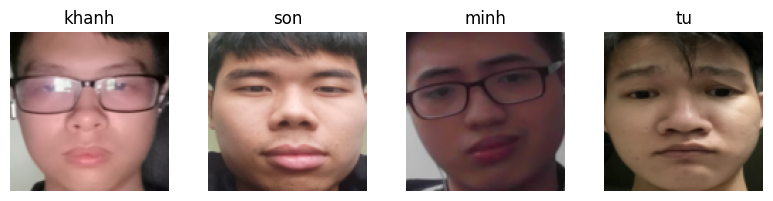

In [9]:
def unnormalize(img):
    img = img * 0.5 + 0.5   # từ [-1,1] về [0,1]
    return img.clip(0,1)

def show_first_batch(dataloader):
    imgs, labels = next(iter(dataloader))
    batch_size = imgs.size(0)
    print(batch_size)
    cols = 8
    rows = (batch_size + cols - 1) // cols
    
    plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(batch_size):
        img = imgs[i].permute(1,2,0).cpu().numpy()
        img = unnormalize(img)
    
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(id_name_map[labels[i].item()])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_first_batch(trn_ld)

4


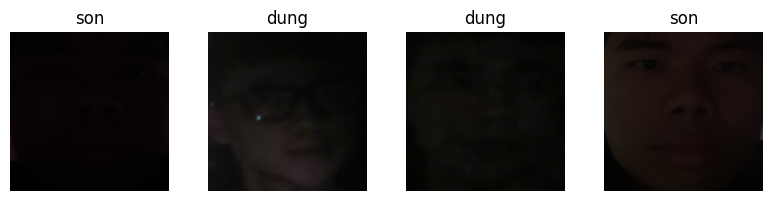

In [8]:
show_first_batch(tst_ld)

# Training

In [42]:
def eval_model(model, data_loader, id_name_map, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    # overall
    correct = 0
    total = 0
    running_loss = 0.0

    # per-class
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            pred = logits.argmax(dim=1)

            # Loss
            loss = criterion(logits, labels)
            running_loss += loss.item()

            # overall
            # print('Pred:', pred)
            # print('Label:', labels)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

            # per-class
            for l, p in zip(labels, pred):
                class_total[l.item()] += 1
                if l == p:
                    class_correct[l.item()] += 1

    # convert to accuracy per class
    class_acc = {}
    for label in class_total:
        acc = class_correct[label] / class_total[label]
        class_acc[id_name_map[label]] = acc

    overall_acc = correct / total
    val_loss = running_loss / len(data_loader)

    return val_loss, overall_acc, class_acc

def train(model, train_loader, val_loader, id_name_map,
          lr=1e-3, num_epochs=10, unfreeze_epoch=3, num_layers_unfreeze=2,
          patience=3, device="cuda"):

    # ----- 0) Early stopping state -----
    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None

    model.to(device)

    # ----- 1) Freeze backbone ban đầu -----
    for p in model.backbone.parameters():
        p.requires_grad = False

    # Optimizer khởi tạo chỉ với params đang train được
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )

    # Contrastive loss
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        # ----- 2) Unfreeze đúng cách tại unfreeze_epoch -----
        if epoch == unfreeze_epoch:
            if num_layers_unfreeze > 0:
                print(f"=== Unfreezing last {num_layers_unfreeze} layers at epoch {epoch} ===")
                model.unfreeze_last_layers(n=num_layers_unfreeze)
    
                optimizer = torch.optim.Adam(
                    filter(lambda p: p.requires_grad, model.parameters()),
                    lr=lr * 0.2
                )
            else:
                print(f"Unfreeze whole backbone")
                
                for p in model.backbone.parameters():
                    p.requires_grad = True

                optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.1)

        # ----------------- Training -----------------
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # ----------------- Validation ----------------
        val_loss, overall_acc, class_acc = eval_model(model, val_loader, id_name_map)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {running_loss/len(train_loader):.4f} "
              f"Val Loss: {val_loss:.4f}")
        print("Overall accuracy:", overall_acc)

        # for cls, acc in class_acc.items():
        #     print(f"{cls}: {acc:.4f}")

        # ----- 3) EARLY STOPPING -----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()  # save best weights
        else:
            patience_counter += 1
            print(f"✗ No improvement. Patience {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("⛔ Early stopping triggered!")
                break

    print("Restoring best model weights...")
    model.load_state_dict(best_state)
    return model

In [149]:
model = BaselineModel(512, len(name_id_map))
model = train(model, trn_ld, val_ld, id_name_map, num_epochs=60, unfreeze_epoch=5, num_layers_unfreeze=2)

[Epoch 1/60] Train Loss: 1.9065 Val Loss: 1.8802
Overall accuracy: 0.4090909090909091
dung: 0.1429
khanh: 0.0000
tu: 0.5000
minh: 1.0000
son: 0.0000
lan: 0.6000
kien: 0.0000
[Epoch 2/60] Train Loss: 1.7238 Val Loss: 1.8100
Overall accuracy: 0.22727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.5000
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
[Epoch 3/60] Train Loss: 1.4886 Val Loss: 1.7293
Overall accuracy: 0.2727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
[Epoch 4/60] Train Loss: 1.2207 Val Loss: 1.6605
Overall accuracy: 0.2727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
[Epoch 5/60] Train Loss: 0.9252 Val Loss: 1.5811
Overall accuracy: 0.36363636363636365
dung: 0.0000
khanh: 0.0000
tu: 1.0000
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 1.0000
=== Unfreezing last 2 layers at epoch 5 ===
[Epoch 6/60] Train Loss: 0.7616 Val Loss: 1.5680
Overall accuracy: 0.272727272727272

In [150]:
eval_model(model, tst_ld, id_name_map)

(1.4265849391619365,
 0.5,
 {'son': 0.25,
  'dung': 0.5714285714285714,
  'tu': 0.75,
  'minh': 0.75,
  'lan': 0.0})

# Synthetic Data
## Darken

In [46]:
def dark_augment(img):
    h, w = img.shape[:2]
    aug = img.copy()

    # Gamma cực thấp để tối mạnh
    gamma = random.uniform(0.15, 0.4)
    inv_gamma = 1.0 / gamma
    table = (np.array([((i / 255.0) ** inv_gamma) * 255
                       for i in np.arange(256)])).astype("uint8")
    aug = cv2.LUT(aug, table)

    # Giảm brightness mạnh
    brightness_factor = random.uniform(0.2, 0.45)
    aug = np.clip(aug * brightness_factor, 0, 255).astype(np.uint8)

    # 3. Noise nhẹ (ISO vừa)
    noise_std = random.randint(3, 8)   # nhẹ, không phá mặt
    noise = np.random.normal(0, noise_std, (h, w, 3))
    aug = np.clip(aug + noise, 0, 255).astype(np.uint8)

    # 4. Blur nhẹ (tùy chọn)
    aug = cv2.GaussianBlur(aug, (3, 3), 0)

    # Color shift vàng nhẹ (tự nhiên)
    shift_b = random.randint(-10, -3)    # giảm Blue nhẹ
    aug[..., 0] = np.clip(aug[..., 0] + shift_b, 0, 255)

    shift_r = random.randint(3, 10)      # tăng Red nhẹ
    aug[..., 2] = np.clip(aug[..., 2] + shift_r, 0, 255)

    if random.random() < 0.5:
        aug = cv2.flip(aug, 1)

    if random.random() < 0.5:
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        aug = cv2.warpAffine(aug, M, (w, h), 
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT_101)

    return aug

def save_augment_images(augment_func, num_augs_for_each, target_dir, save_dir, show_im=False):
    for img_path in all_image_dict[target_dir]:
        image = cv2.imread(img_path)
        for i in range(num_augs_for_each):
            processed_img = augment_func(image)
        
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
        
            img_name = f"{img_path.split('/')[-2]}/{i}-{img_path.split('/')[-1]}"
            os.makedirs(f"data/{save_dir}/{img_path.split('/')[-2]}", exist_ok=True)
            cv2.imwrite(f'data/{save_dir}/{img_name}', processed_img)
            # print(f'Successfully write data/{save_dir}/{img_name}')
            
            if show_im:
                plt.figure(figsize=(8,4))
            
                plt.subplot(1, 2, 1)
                plt.imshow(img_rgb)
                plt.title(img_path)
                plt.axis("off")
            
                plt.subplot(1, 2, 2)
                plt.imshow(processed_rgb)
                plt.title(img_path)
                plt.axis("off")
            
                plt.show()

    print('Success')

save_augment_images(dark_augment, 2, 'normal', 'darken_normal_for_finetune') 

Success


## CLAHE Lighten

In [16]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# save_augment_images(apply_clahe, 1, 'low_light', 'clahe_lighten_low_light')

In [96]:
new_image_dict = build_image_dict('data')
for k, v in new_image_dict.items():
    print(k, len(v))

new_image_dict.pop('clahe_lighten_low_light')
draw_pca(new_image_dict)

clahe_lighten_low_light 45
normal 43
low_light 45
darken_normal 129
Extracting embeddings for normal (43 images)...
Batch shape: torch.Size([43, 3, 112, 112])
Extracting embeddings for low_light (45 images)...
Batch shape: torch.Size([45, 3, 112, 112])
Extracting embeddings for darken_normal (129 images)...
Batch shape: torch.Size([129, 3, 112, 112])


'pca_plot_20251210_103944.png'

In [10]:
trn_ld, val_ld, tst_ld, name_id_map = build_dataloaders(['normal', 'darken_normal'], ['low_light'], root="data", pct=0.5, batch_size=8)

print(len(trn_ld.dataset))
print(len(val_ld.dataset))
print(len(tst_ld.dataset))
print(name_id_map)
id_name_map = {v: k for k, v in name_id_map.items()}

173
22
22
{'khanh': 0, 'tu': 1, 'minh': 2, 'lan': 3, 'dung': 4, 'son': 5, 'kien': 6}


8


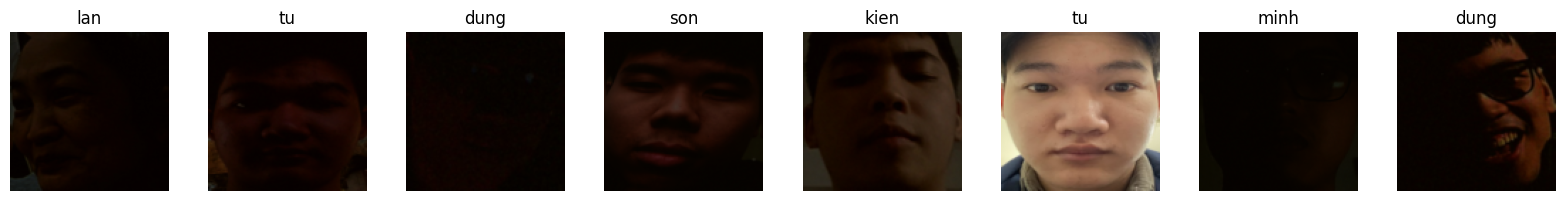

In [119]:
show_first_batch(trn_ld)

8


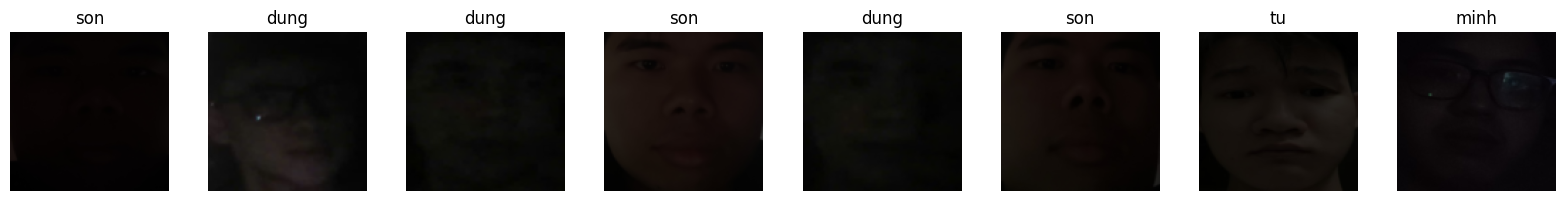

In [120]:
show_first_batch(tst_ld)

In [121]:
model = BaselineModel(512, len(name_id_map))
model = train(model, trn_ld, val_ld, id_name_map, num_epochs=30)

[Epoch 1/30] Train Loss: 1.8358 Val Loss: 1.8496
Overall accuracy: 0.18181818181818182
dung: 0.0000
khanh: 0.0000
tu: 0.2500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
[Epoch 2/30] Train Loss: 1.4382 Val Loss: 1.7851
Overall accuracy: 0.3181818181818182
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 1.0000
[Epoch 3/30] Train Loss: 0.9657 Val Loss: 1.7649
Overall accuracy: 0.3181818181818182
dung: 0.1429
khanh: 0.0000
tu: 0.7500
minh: 0.6667
son: 0.0000
lan: 0.0000
kien: 1.0000
=== Unfreezing backbone at epoch 3 ===
[Epoch 4/30] Train Loss: 0.6746 Val Loss: 1.8366
Overall accuracy: 0.3181818181818182
dung: 0.1429
khanh: 0.0000
tu: 0.7500
minh: 0.6667
son: 0.0000
lan: 0.0000
kien: 1.0000
✗ No improvement. Patience 1/3
[Epoch 5/30] Train Loss: 0.5423 Val Loss: 1.8268
Overall accuracy: 0.4090909090909091
dung: 0.4286
khanh: 0.0000
tu: 0.7500
minh: 0.6667
son: 0.0000
lan: 0.0000
kien: 1.0000
✗ No improvement. Patience 2/3
[Epoch 6/30] Train Loss: 0.4

In [122]:
eval_model(model, tst_ld, id_name_map)

(1.7922042608261108,
 0.3181818181818182,
 {'son': 0.25,
  'dung': 0.2857142857142857,
  'tu': 0.75,
  'minh': 0.25,
  'lan': 0.0})

# Our method
## Model

In [11]:
class ContrastiveBackbone(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()

        model_name = "edgeface_xxs"
        backbone = get_model(model_name)
        checkpoint_path = f"checkpoints/{model_name}.pt"
        backbone.load_state_dict(torch.load(checkpoint_path, map_location=device))

        self.backbone = backbone

    def forward(self, x1, x2):
        z1 = self.backbone(x1)
        z2 = self.backbone(x2)
        return z1, z2

## Augment ảnh sáng vẫn rõ mặt

In [151]:
def light_augment(img):
    h, w = img.shape[:2]
    out = img.copy()

    # ---- 1) CLAHE nhẹ (tăng local contrast nhưng giữ brightness) ----
    lab = cv2.cvtColor(out, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    out = cv2.cvtColor(cv2.merge([l2, a, b]), cv2.COLOR_LAB2BGR)

    # ---- 2) Vignette rất nhỏ (giảm viền 5–10%) ----
    if random.random() < 0.5:
        kernel_x = cv2.getGaussianKernel(w, w/2)
        kernel_y = cv2.getGaussianKernel(h, h/2)
        mask = kernel_y @ kernel_x.T
        mask = mask / mask.max()
        mask = 0.9 + 0.1 * mask  # nổi bật trung tâm nhưng rất nhẹ
        vignette = (out * mask[..., None]).astype(np.uint8)
        out = vignette

    # ---- 3) Light spot (tăng sáng vùng nhỏ, không đổi global brightness) ----
    if random.random() < 0.5:
        cx = random.randint(w//4, 3*w//4)
        cy = random.randint(h//4, 3*h//4)
        radius = random.randint(int(0.2*min(h,w)), int(0.4*min(h,w)))

        Y, X = np.ogrid[:h, :w]
        dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
        mask = 1 + 0.15 * np.clip(1 - dist/radius, 0, 1)  # +15% sáng vùng đó
        light = np.clip(out * mask[..., None], 0, 255).astype(np.uint8)
        out = light

    # ---- 4) Shadow nhẹ (không quá 10–15%) ---
    if random.random() < 0.5:
        x1 = random.randint(0, w//2)
        y1 = random.randint(0, h//2)
        x2 = random.randint(w//2, w)
        y2 = random.randint(h//2, h)

        shadow_mask = np.zeros((h, w), dtype=np.float32)
        cv2.rectangle(shadow_mask, (x1, y1), (x2, y2), 1, -1)
        shadow_mask = cv2.GaussianBlur(shadow_mask, (99, 99), 30)
        shadow = 1 - 0.15 * shadow_mask  # giảm sáng tối đa 15%

        out = np.clip(out * shadow[..., None], 0, 255).astype(np.uint8)

    if random.random() < 0.5:
        out = cv2.flip(out, 1)

    if random.random() < 0.5:
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        out = cv2.warpAffine(out, M, (w, h), 
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT_101)

    return out

# save_augment_images(light_augment, 3, 'normal', 'augment_normal')

## Pretrain Dataloader

In [70]:
class PairedLightDarkDataset(Dataset):
    def __init__(self, light_map, dark_map):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((112,112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],
                                 std=[0.5,0.5,0.5]),
        ])

        # 1) gom ảnh theo ID người
        self.light_map = light_map  # id → list of images
        self.dark_map = dark_map

        # 2) chỉ lấy các id xuất hiện trong cả sáng và tối
        self.person_ids = [
            pid for pid in self.light_map.keys()
            if pid in self.dark_map
        ]

        if len(self.person_ids) == 0:
            raise ValueError("❌ Không có ID nào xuất hiện ở cả ảnh sáng và tối!")

    def __len__(self):
        return len(self.person_ids)

    def __getitem__(self, idx):
        # weights = [1, 0, 0]
        weights = [0, 1.2, 1]
        choice = random.choices(['pull_2_dark', 'push_2_dark', 'pull_light_dark'], weights)
        # is_positive = random.random() < 0.5

        if choice == ['pull_light_dark']:
            pid = random.choice(self.person_ids)
            p1 = random.choice(self.light_map[pid])
            p2 = random.choice(self.dark_map[pid])
            target = torch.tensor(1.0)
        elif choice == ['pull_2_dark']:
            pid = random.choice(self.person_ids)
            p1, p2 = random.sample(self.dark_map[pid], 2)
            target = torch.tensor(1.0)
        else:
            pid1, pid2 = random.sample(self.person_ids, 2)
            p1 = random.choice(self.dark_map[pid1])
            p2 = random.choice(self.dark_map[pid2])
            target = torch.tensor(-1.0)
            
        img1 = cv2.cvtColor(cv2.imread(p1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(p2), cv2.COLOR_BGR2RGB)

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return img1, img2, target

light_paths, light_ids, dark_paths, dark_ids, _ = load_image_paths(['normal'], ['darken_normal'])

light_map = defaultdict(list)
dark_map = defaultdict(list)
for id, path in zip(light_ids, light_paths):
    light_map[id].append(path)
for id, path in zip(dark_ids, dark_paths):
    dark_map[id].append(path)

pretrn_ds = PairedLightDarkDataset(light_map, dark_map)
pretrn_ld = DataLoader(pretrn_ds, batch_size=8192, shuffle=True)
trn_ld, val_ld, tst_ld, name_id_map = build_dataloaders(['normal'], ['low_light'], root="data", pct=0.5, batch_size=4)

print(len(trn_ld.dataset))
print(len(val_ld.dataset))
print(len(tst_ld.dataset))
print(name_id_map)

id_name_map = {v: k for k, v in name_id_map.items()}

44
22
22
{'khanh': 0, 'tu': 1, 'minh': 2, 'lan': 3, 'dung': 4, 'son': 5, 'kien': 6}


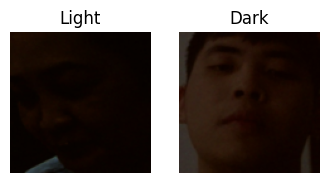

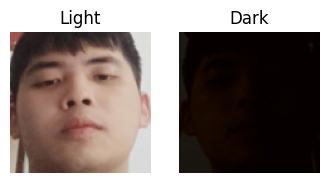

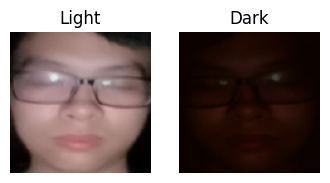

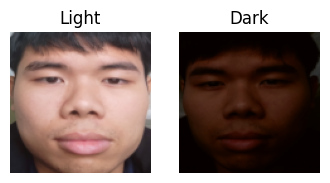

In [37]:
batch = next(iter(pretrn_ld))
x_light, x_dark, _ = batch

for i in range(4):
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow(unnormalize(x_light[i]).permute(1,2,0))
    plt.title("Light")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(unnormalize(x_dark[i]).permute(1,2,0))
    plt.title("Dark")
    plt.axis('off')
    
    plt.show()

In [64]:
def pretrain(model, dataloader, num_epochs=10, lr=1e-4,
             patience=3, device="cuda", 
             use_pretrain=True, use_early_stopping=True):

    if not use_pretrain:
        print("⚠️ Bỏ qua bước pretrain (use_pretrain=False)")
        return model

    model.to(device)
    model.train()

    criterion = nn.CosineEmbeddingLoss(margin=0.11)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss = float("inf")
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        running_loss = 0.0

        for img1, img2, target in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            z1, z2 = model(img1, img2)
            loss = criterion(z1, z2, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

        # ====== Early Stopping optional ======
        if use_early_stopping:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
                print(f"  👉 Improved! Saving best model (loss={best_loss:.4f})")
            else:
                no_improve_epochs += 1
                print(f"  ❌ No improvement ({no_improve_epochs}/{patience})")

            if no_improve_epochs >= patience:
                print("⛔ Early stopping triggered!")
                break

        else:
            # Không dùng early stopping → vẫn update best model lần đầu
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = copy.deepcopy(model.state_dict())
                print('Best Epoch:', epoch)

    # ====== Restore best model ======
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print("🌟 Pretrain hoàn tất!")
    return model

model_bb = ContrastiveBackbone()
model_bb = pretrain(model_bb, pretrn_ld, num_epochs=100, use_early_stopping=True, patience=15)

[Epoch 1/100] Loss: 0.1161
  👉 Improved! Saving best model (loss=0.1161)
[Epoch 2/100] Loss: 0.3019
  ❌ No improvement (1/15)
[Epoch 3/100] Loss: 0.3195
  ❌ No improvement (2/15)
[Epoch 4/100] Loss: 0.2425
  ❌ No improvement (3/15)
[Epoch 5/100] Loss: 0.0287
  👉 Improved! Saving best model (loss=0.0287)
[Epoch 6/100] Loss: 0.4445
  ❌ No improvement (1/15)
[Epoch 7/100] Loss: 0.2253
  ❌ No improvement (2/15)
[Epoch 8/100] Loss: 0.3559
  ❌ No improvement (3/15)
[Epoch 9/100] Loss: 0.3261
  ❌ No improvement (4/15)
[Epoch 10/100] Loss: 0.3551
  ❌ No improvement (5/15)
[Epoch 11/100] Loss: 0.3566
  ❌ No improvement (6/15)
[Epoch 12/100] Loss: 0.2834
  ❌ No improvement (7/15)
[Epoch 13/100] Loss: 0.3982
  ❌ No improvement (8/15)
[Epoch 14/100] Loss: 0.2631
  ❌ No improvement (9/15)
[Epoch 15/100] Loss: 0.3901
  ❌ No improvement (10/15)
[Epoch 16/100] Loss: 0.3577
  ❌ No improvement (11/15)
[Epoch 17/100] Loss: 0.2500
  ❌ No improvement (12/15)
[Epoch 18/100] Loss: 0.1284
  ❌ No improvement (

## New PCA

In [65]:
all_image_dict = build_image_dict("data", split_by_person=True)

all_image_dict = {
    key: value
    for key, value in all_image_dict.items()
    if not (key.startswith('clahe_lighten_low_light') or key.startswith('darken_normal') or key.startswith('normal'))
}

# model_bb = ContrastiveBackbone()
draw_pca(model_bb, all_image_dict)

all_image_dict = build_image_dict("data", split_by_person=False)

all_image_dict = {
    key: value
    for key, value in all_image_dict.items()
    if not (key.startswith('clahe_lighten_low_light') or key.startswith('darken_normal'))
}

# model_bb = ContrastiveBackbone()
draw_pca(model_bb, all_image_dict)

Extracting embeddings for low_light/khanh (1 images)...
Batch shape: torch.Size([1, 3, 112, 112])
Extracting embeddings for low_light/tu (8 images)...
Batch shape: torch.Size([8, 3, 112, 112])
Extracting embeddings for low_light/minh (7 images)...
Batch shape: torch.Size([7, 3, 112, 112])
Extracting embeddings for low_light/lan (8 images)...
Batch shape: torch.Size([8, 3, 112, 112])
Extracting embeddings for low_light/dung (15 images)...
Batch shape: torch.Size([15, 3, 112, 112])
Extracting embeddings for low_light/son (5 images)...
Batch shape: torch.Size([5, 3, 112, 112])
Extracting embeddings for low_light/kien (1 images)...
Batch shape: torch.Size([1, 3, 112, 112])
Extracting embeddings for normal (43 images)...
Batch shape: torch.Size([43, 3, 112, 112])
Extracting embeddings for low_light (45 images)...
Batch shape: torch.Size([45, 3, 112, 112])


'pca_plot/pca_plot_20251210_233153.png'

In [71]:
class ContrastiveModel(nn.Module):
    def __init__(self, pretrained_backbone, embed_dim=512, num_classes=7, num_unfreeze_layers=2):
        super().__init__()

        # lấy backbone đã pretrain
        self.backbone = pretrained_backbone.backbone
        self.unfreeze_last_layers(num_unfreeze_layers)

        self.head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def unfreeze_last_layers(self, n=2):
        for param in self.backbone.parameters():
            param.requires_grad = False

        layers = list(self.backbone.children())

        for layer in layers[-n:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.backbone(x)
        return self.head(embeddings)

model_bb = load_model(ContrastiveBackbone(), 'models/best_bb_state_dict.pt')
model = ContrastiveModel(model_bb)
model = train(model, trn_ld, val_ld, id_name_map, num_epochs=100, unfreeze_epoch=4, num_layers_unfreeze=2, patience=5)

✅ Đã tải và áp dụng state_dict thành công.
[Epoch 1/100] Train Loss: 1.9212 Val Loss: 1.8958
Overall accuracy: 0.18181818181818182
[Epoch 2/100] Train Loss: 1.7440 Val Loss: 1.8398
Overall accuracy: 0.18181818181818182
[Epoch 3/100] Train Loss: 1.5509 Val Loss: 1.7671
Overall accuracy: 0.13636363636363635
[Epoch 4/100] Train Loss: 1.3083 Val Loss: 1.6821
Overall accuracy: 0.3181818181818182
=== Unfreezing last 2 layers at epoch 4 ===
[Epoch 5/100] Train Loss: 1.1271 Val Loss: 1.6667
Overall accuracy: 0.36363636363636365
[Epoch 6/100] Train Loss: 1.0752 Val Loss: 1.6518
Overall accuracy: 0.36363636363636365
[Epoch 7/100] Train Loss: 1.0154 Val Loss: 1.6377
Overall accuracy: 0.36363636363636365
[Epoch 8/100] Train Loss: 0.9733 Val Loss: 1.6223
Overall accuracy: 0.36363636363636365
[Epoch 9/100] Train Loss: 0.9352 Val Loss: 1.6085
Overall accuracy: 0.4090909090909091
[Epoch 10/100] Train Loss: 0.8916 Val Loss: 1.5955
Overall accuracy: 0.4090909090909091
[Epoch 11/100] Train Loss: 0.8463 V

In [72]:
eval_model(model, tst_ld, id_name_map)

(1.1034658054510753,
 0.6818181818181818,
 {'son': 0.25,
  'dung': 0.8571428571428571,
  'tu': 1.0,
  'minh': 0.75,
  'lan': 0.3333333333333333})

In [73]:
save_model(model, 'models/best_model.pt')

✅ Đã lưu state_dict thành công tại: models/best_model_state_dict.pt


In [74]:
model = load_model(ContrastiveModel(ContrastiveBackbone()), 'models/best_model_state_dict.pt').to(device)
eval_model(model, tst_ld, id_name_map)

✅ Đã tải và áp dụng state_dict thành công.


(1.1034658054510753,
 0.6818181818181818,
 {'son': 0.25,
  'dung': 0.8571428571428571,
  'tu': 1.0,
  'minh': 0.75,
  'lan': 0.3333333333333333})